In [35]:
import numpy as np
import pandas as pd

import json
import itertools
import random
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from matplotlib import pyplot as plt
import seaborn as sns

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import util

%matplotlib inline

## Pull Spotify Data

In [2]:
CLIENT_ID="810e2eec841546269c49f338f1be189a"
CLIENT_SECRET="764290d0ab0f4f4484b0d4c7b701bdee"

token = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)

cache_token = token.get_access_token()
sp = spotipy.Spotify(cache_token)

In [3]:
# Pull data
TRACK_DATA_PATH = "data/tracks_5kalbums.json"
with open(TRACK_DATA_PATH,'r') as ff:
    songs = json.load(ff)
    
# Remove duplicates
songs.sort()
songs = list(s for s,_ in itertools.groupby(songs))
print("Loaded {} songs from {}".format(len(songs), TRACK_DATA_PATH))
print("First ten songs: {}".format(songs[:10]))

Loaded 11841 songs from data/tracks_5kalbums.json
First ten songs: [['000InFFKfurNhrCj7yfMdM', 'Park Bench People', 1], ['003eoIwxETJujVWmNFMoZy', 'Growing Pains', 70], ['00518PumkDdn560MsfLofT', 'The Fuss', 46], ['005FoVr63RI753jsNjfLax', 'Black Panther', 31], ['009Mof2o4aS1P2l3FbaEpa', 'Quetzal', 30], ['009TjPzPuetzFiJNnBEVrV', 'Used and Abused', 51], ['00I0pcNkN3IOX3fsYbaB4N', 'Infatuation', 68], ['00KiXBZT9vf1XhcqkFrzug', 'Downward', 46], ['00KjOnN3U40e3lXFUOue7h', '10AM/Save The World (feat. Gucci Mane)', 69], ['00Le8soPbjYT0TxmXflHmi', 'A God Who Sees (Me & Lucy)', 39]]


## Data Exploration

/Users/etang/dev/SoundScorer221/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


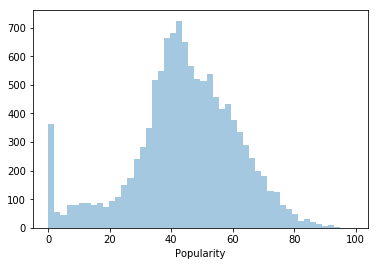

In [4]:
# Plot popularity distribution
sns.distplot([s[2] for s in songs], rug=False, kde=False, axlabel="Popularity")

In [5]:
# Extract top 5 most popular songs
sorted(songs, key=lambda song: song[2])[-10:]

[['0s3nnoMeVWz3989MkNQiRf', 'Lucid Dreams', 93],
 ['14JzyD6FlBD5z0wV5P07YI', "when the party's over", 93],
 ['1xzBco0xcoJEDXktl7Jxrr', 'Mo Bamba', 93],
 ['3EPXxR3ImUwfayaurPi3cm', 'Be Alright', 93],
 ['0d2iYfpKoM0QCKvcLCkBao', 'Eastside (with Halsey & Khalid)', 94],
 ['1A6OTy97kk0mMdm78rHsm8',
  'Sunflower - Spider-Man: Into the Spider-Verse',
  95],
 ['2xLMifQCjDGFmkHkpNLD9h', 'SICKO MODE', 95],
 ['7l3E7lcozEodtVsSTCkcaA', 'ZEZE (feat. Travis Scott & Offset)', 95],
 ['5p7ujcrUXASCNwRaWNHR1C', 'Without Me', 96],
 ['4w8niZpiMy6qz1mntFA5uM',
  'Taki Taki (with Selena Gomez, Ozuna & Cardi B)',
  99]]

## Feature Extraction

In [6]:
# audio_features provides high-level Echo Nest features
sp.audio_features(songs[0][0])

[{'danceability': 0.658,
  'energy': 0.379,
  'key': 5,
  'loudness': -11.763,
  'mode': 0,
  'speechiness': 0.0444,
  'acousticness': 0.367,
  'instrumentalness': 0.000493,
  'liveness': 0.0728,
  'valence': 0.81,
  'tempo': 135.991,
  'type': 'audio_features',
  'id': '000InFFKfurNhrCj7yfMdM',
  'uri': 'spotify:track:000InFFKfurNhrCj7yfMdM',
  'track_href': 'https://api.spotify.com/v1/tracks/000InFFKfurNhrCj7yfMdM',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/000InFFKfurNhrCj7yfMdM',
  'duration_ms': 315707,
  'time_signature': 4}]

In [7]:
''' Returns a list of each track's audio features'''
def features(songs):
    all_feats = []
    ids = [song[0] for song in songs]
    # Spotify's audio_features can only return 50 songs at once
    for i in range(0, len(songs), 50):
        track_feats = sp.audio_features(ids[i:i+50])
        for j in range(len(track_feats)):
            if not track_feats[j]:
                continue # song not found in Spotify
            track_feats[j]['name'] = songs[i+j][1]
            track_feats[j]['popularity'] = songs[i+j][2]
        all_feats.extend(filter(None, track_feats))
    return all_feats

In [8]:
feats = features(songs)
feats[100]

{'danceability': 0.964,
 'energy': 0.502,
 'key': 0,
 'loudness': -7.604,
 'mode': 1,
 'speechiness': 0.191,
 'acousticness': 0.00383,
 'instrumentalness': 0,
 'liveness': 0.0874,
 'valence': 0.551,
 'tempo': 127.993,
 'type': 'audio_features',
 'id': '04yv0dtqVm9u745efIuxbZ',
 'uri': 'spotify:track:04yv0dtqVm9u745efIuxbZ',
 'track_href': 'https://api.spotify.com/v1/tracks/04yv0dtqVm9u745efIuxbZ',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/04yv0dtqVm9u745efIuxbZ',
 'duration_ms': 263933,
 'time_signature': 4,
 'name': 'On The Run (feat. Offset)',
 'popularity': 69}

#### Artist Feature Extraction

In [9]:
def get_trackid_artistid_dict(tracks):
    """
    Given list of track_ids
    returns dictionary from all track_ids to artist IDs
    """
    track_artist_dict = {}
    for i in range(0, len(tracks), 50):
        track_ids = tracks[i : i + 50]
        track_infos = sp.tracks(track_ids)["tracks"]
        assert len(track_ids) == len(track_infos)
        for track_id, info in zip(track_ids, track_infos):
            if not info:
                continue # song not found in Spotify
            track_artist_dict[track_id] = info["artists"][0]["id"]
        if len(track_artist_dict) % 1000 == 0:
            print("Stored {} artist IDs".format(len(track_artist_dict)))
            print(list(track_artist_dict.items())[-1:])
    print("Stored {} artist IDs".format(len(track_artist_dict)))
    return track_artist_dict

In [10]:
def get_artistid_to_features_dict(artist_ids):
    """
    Given iterable of artist_ids, returns a map from artist_id to feature_dict for each artist
    e.g. {"093sDFBR924": {"followers" : 1038, "genres": ["pop", "rock"]},
            "RV3910FWS": {"followers" : 31001, "genres": ["country"]}
    """
    feature_dict = {}
    unique_ids = list(set(artist_ids))
    for i in range(0, len(unique_ids), 50):
        artist_ids_chunk = unique_ids[i : i + 50]
        artist_infos = sp.artists(artist_ids_chunk)["artists"]
        assert len(artist_infos) == len(artist_ids_chunk)
        for artist_id, info in zip(artist_ids_chunk, artist_infos):
            if not info:
                continue
            feature_dict[artist_id] = {
                "artist_followers": info["followers"]["total"],
                "artist_popularity": info["popularity"],
                "artist_genres": info["genres"]
            }
        if len(feature_dict) % 1000 == 0:
            print("Stored {} artists' features".format(len(feature_dict)))
            print(list(feature_dict.items())[-1:])
    print("Stored {} artists' features".format(len(feature_dict)))
    return feature_dict

In [11]:
def add_artist_features(features_list):
    """
    Takes in a list of feature dictionaries, adds artist features
    Requires that track_id be a feature in each song
    """
    # TODO: Could speed up by adding parameters to read or write these dictionaries from files
    features_list = feats
    track_ids = [f["id"] for f in features_list]
    print("BUILDING TRACK ID -> ARTIST ID DICTIONARY")
    track_artist_dict = get_trackid_artistid_dict(track_ids) 
    artist_ids = list(set(track_artist_dict.values()))
    print("BUILDING ARTIST ID -> ARTIST FEATURES DICTIONARY")
    artist_feature_dict = get_artistid_to_features_dict(artist_ids)
    features_list = [f for f in features_list if f["id"] in track_artist_dict and track_artist_dict[f["id"]] in artist_feature_dict]
    for features in features_list:
        track_artist_features = artist_feature_dict[track_artist_dict[features["id"]]]
        features.update(track_artist_features)
    return features_list

In [12]:
feats = add_artist_features(feats)
feats[100]

BUILDING TRACK ID -> ARTIST ID DICTIONARY
Stored 1000 artist IDs
[('0hpVsKtKOhxY3QYtzat4YI', '25KNo5GDS6ZpLkjasaecA3')]
Stored 2000 artist IDs
[('1M732H32aWAHYGDBOFU2br', '2J0JN7EFN10G1Tty6hX0AN')]
Stored 3000 artist IDs
[('21QNvLDoeQS1G4FxRvZNBL', '0Y4inQK6OespitzD6ijMwb')]
Stored 4000 artist IDs
[('2gafFAtDIGgDQLiEpRokIx', '57DlMWmbVIf2ssJ8QBpBau')]
Stored 5000 artist IDs
[('3LjvFUqQi5LoqaRK6CLwMk', '1dfeR4HaWDbWqFHLkxsg1d')]
Stored 6000 artist IDs
[('3y6GnNl3mK2Rqw5N6vA5Se', '74gcBzlQza1bSfob90yRhR')]
Stored 7000 artist IDs
[('4eLHWCv6pLrxvpKomdGx5w', '57DlMWmbVIf2ssJ8QBpBau')]
Stored 8000 artist IDs
[('5J3Rb54DgCiN1OLIuKu1sL', '2vGA5qCDLZGW6exRQgKfLL')]
Stored 9000 artist IDs
[('60mz2UG8P6BTE0sSl1MNMJ', '1vaOLxWPpsv5LVsSHBy9tF')]
Stored 10000 artist IDs
[('6gC1f3S8JdxFHcOTlz1sLC', '6JaSyvyg28SHC0Of8YE6M9')]
Stored 11000 artist IDs
[('7InCc97CcXdcFzla1zPWJS', '5aBxFPaaGk9204ssHUvXWN')]
Stored 11741 artist IDs
BUILDING ARTIST ID -> ARTIST FEATURES DICTIONARY
Stored 1000 artists' feat

{'danceability': 0.964,
 'energy': 0.502,
 'key': 0,
 'loudness': -7.604,
 'mode': 1,
 'speechiness': 0.191,
 'acousticness': 0.00383,
 'instrumentalness': 0,
 'liveness': 0.0874,
 'valence': 0.551,
 'tempo': 127.993,
 'type': 'audio_features',
 'id': '04yv0dtqVm9u745efIuxbZ',
 'uri': 'spotify:track:04yv0dtqVm9u745efIuxbZ',
 'track_href': 'https://api.spotify.com/v1/tracks/04yv0dtqVm9u745efIuxbZ',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/04yv0dtqVm9u745efIuxbZ',
 'duration_ms': 263933,
 'time_signature': 4,
 'name': 'On The Run (feat. Offset)',
 'popularity': 69,
 'artist_followers': 3521215,
 'artist_popularity': 88,
 'artist_genres': ['atl hip hop',
  'gangster rap',
  'hip hop',
  'pop',
  'pop rap',
  'rap',
  'trap music']}

In [100]:
def format_genre_features(features_list, feature_cutoff=0.01):
    """
    Returns (updated features, feature_genres)
    """
    genre_counts = Counter(g for f in features_list for g in f["artist_genres"])
    print("Number of genres: {}".format(len(genre_counts)))
    print("Most popular genres: {}".format(genre_counts.most_common(10)))
    feature_cutoff_num = feature_cutoff * len(features_list)
    feature_genres = set([g for g in genre_counts if genre_counts[g] >= feature_cutoff_num])
    print("Number of featurized genres: {}".format(len(feature_genres)))
    for feat in features_list:
        for genre in feature_genres:
            feat["genre_" + genre] = 1 if genre in feat["artist_genres"] else 0
    feature_genres = ["genre_" + g + "" for g in feature_genres]
    return features_list, feature_genres

In [101]:
feats, feature_genres = format_genre_features(feats)

Number of genres: 552
Most popular genres: [('pop', 1923), ('rap', 1744), ('trap music', 1525), ('pop rap', 1261), ('hip hop', 1120), ('southern hip hop', 966), ('dance pop', 910), ('underground hip hop', 848), ('modern rock', 721), ('vapor trap', 721)]
Number of featurized genres: 88


In [102]:
data = pd.DataFrame(feats)
data = data.sample(frac=1)
data.head()

,acousticness,album rock,alternative hip hop,alternative metal,analysis_url,anthem worship,art pop,artist_followers,artist_genres,artist_popularity,...,underground hip hop,urban contemporary,uri,valence,vapor soul,vapor trap,video game music,viral pop,world worship,worship
1963,0.4220,0,0,0,https://api.spotify.com/v1/audio-analysis/1KlF...,0,0,14752,"[chamber pop, folk-pop, indie anthem-folk, ind...",58,...,0,0,spotify:track:1KlFxJ4ndfxpP1NoqRkIEg,0.315,0,0,0,0,0,0
2082,0.0544,0,0,0,https://api.spotify.com/v1/audio-analysis/1PPH...,0,0,12880096,"[reggaeton, trap latino]",97,...,0,0,spotify:track:1PPHqTL7IpYToKeIuA5pi9,0.743,0,0,0,0,0,0
11738,0.2910,0,0,0,https://api.spotify.com/v1/audio-analysis/7zwH...,0,0,108598,"[australian indie, australian pop]",62,...,0,0,spotify:track:7zwHxedNwwUJn151jiurfp,0.802,0,0,0,0,0,0
6338,0.1800,0,0,0,https://api.spotify.com/v1/audio-analysis/4CFl...,0,0,111749,"[dance pop, electropop, indie poptimism, pop, ...",70,...,0,0,spotify:track:4CFlDepqivJp9ECpBZOv0s,0.626,0,0,0,0,0,0
5099,0.3710,0,0,0,https://api.spotify.com/v1/audio-analysis/3PGu...,0,0,2118221,"[dance pop, dancehall, pop, pop rap]",83,...,0,0,spotify:track:3PGubBdFfQSHAHsXb068eG,0.444,0,0,0,0,0,0


In [103]:
data.loc[data['popularity'] >= 95]

,acousticness,album rock,alternative hip hop,alternative metal,analysis_url,anthem worship,art pop,artist_followers,artist_genres,artist_popularity,...,underground hip hop,urban contemporary,uri,valence,vapor soul,vapor trap,video game music,viral pop,world worship,worship
11385,0.05150,0,0,0,https://api.spotify.com/v1/audio-analysis/7l3E...,0,0,3910095,"[pop, pop rap, rap, trap music]",91,...,0,0,spotify:track:7l3E7lcozEodtVsSTCkcaA,0.474,0,0,0,0,0,0
1693,0.55100,0,0,0,https://api.spotify.com/v1/audio-analysis/1A6O...,0,0,8956186,"[pop, rap]",96,...,0,0,spotify:track:1A6OTy97kk0mMdm78rHsm8,0.927,0,0,0,0,0,0
8713,0.29700,0,0,0,https://api.spotify.com/v1/audio-analysis/5p7u...,0,0,4410501,"[dance pop, electropop, etherpop, indie poptim...",91,...,0,0,spotify:track:5p7ujcrUXASCNwRaWNHR1C,0.533,0,0,0,0,0,0
4392,0.00513,0,0,0,https://api.spotify.com/v1/audio-analysis/2xLM...,0,0,3818730,"[pop, pop rap, rap]",96,...,0,0,spotify:track:2xLMifQCjDGFmkHkpNLD9h,0.446,0,0,0,0,0,0
7452,0.15300,0,0,0,https://api.spotify.com/v1/audio-analysis/4w8n...,0,0,3564751,"[dance pop, edm, electronic trap, pop, tropica...",89,...,0,0,spotify:track:4w8niZpiMy6qz1mntFA5uM,0.591,0,0,0,0,0,0


In [104]:
features = ["acousticness", "danceability", "energy", 
            "loudness", "speechiness", "tempo", "valence", "artist_followers"] + feature_genres

In [105]:
train, test = train_test_split(data, test_size=0.15)
train, dev = train_test_split(train, test_size=0.15/0.85)
x_train, y_train = train[features], train["popularity"]
x_dev, y_dev = dev[features], dev["popularity"]
x_test, y_test = test[features], test["popularity"]
print("Training size: {}, Dev size: {}, Test size: {}".format(len(train), len(dev), len(test)))

Training size: 8217, Dev size: 1762, Test size: 1762


## Baseline (Linear Regression)

In [106]:
lin_mod = LinearRegression()
lin_mod.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [107]:
test_preds = lin_mod.predict(x_dev)
print("Mean Squared Error: {}".format(mean_squared_error(test_preds, y_dev)))
print("Variance Score: {}".format(r2_score(test_preds, y_dev)))

Mean Squared Error: 197.33165086038258
Variance Score: -1.1427639501563758


In [108]:
coeffs = dict(zip(features, lin_mod.coef_))
print("Model coefficients: {}".format(coeffs))

Model coefficients: {'acousticness': 0.714670921984008, 'danceability': 6.870661580974536, 'energy': -2.233456149243734, 'loudness': 0.5805356687259526, 'speechiness': -7.848528174557847, 'tempo': 0.005769353711743433, 'valence': -3.338143721315667, 'artist_followers': 1.2432913519691127e-06, 'genre_anthem worship': -4.759852648437567, 'genre_latin': 5.955150679199994, 'genre_alternative metal': 2.0104413543290818, 'genre_post-grunge': 2.897429398422697, 'genre_conscious hip hop': 12.68034608212425, 'genre_hip hop': -1.6493135896603768, 'genre_worship': -0.004694790329502707, 'genre_country': -8.647000205213963, 'genre_christian music': 15.24165019065309, 'genre_pop rap': -5.408257774231692, 'genre_southern hip hop': -8.374496465233195, 'genre_k-pop': 4.127621287265006, 'genre_jazz boom bap': -13.341215653822783, 'genre_scorecore': -4.472456803300955, 'genre_pop': 2.0078318710886025, 'genre_metalcore': 0.3968430768451867, 'genre_edm': -5.056265173886213, 'genre_ccm': -18.03465077039998

## SVM 

In [109]:
svr = SVR(C=10)
svr.fit(x_train, y_train)

/Users/etang/dev/SoundScorer221/venv/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [110]:
test_preds = svr.predict(x_dev)
print("SVM Mean Squared Error: {}".format(mean_squared_error(test_preds, y_dev)))
print("SVM Variance Score: {}".format(r2_score(test_preds, y_dev)))

SVM Mean Squared Error: 177.0862566419048
SVM Variance Score: -0.9715389858705656


## Random Forest

In [111]:
random_forest = RandomForestRegressor(n_estimators=200, random_state=0)
random_forest.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [112]:
test_preds = random_forest.predict(x_dev)
print("Random Forest Mean Squared Error: {}".format(mean_squared_error(test_preds, y_dev)))
print("Random Forest Variance Score: {}".format(r2_score(test_preds, y_dev)))

Random Forest Mean Squared Error: 145.82230495382973
Random Forest Variance Score: -0.09772407777870895


## Gradient Boosting Regressor

In [113]:
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=0)
gbr.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [114]:
test_preds = gbr.predict(x_dev)
print("Gradient Boosting Regressor Mean Squared Error: {}".format(mean_squared_error(test_preds, y_dev)))
print("Gradient Boosting Regressor Variance Score: {}".format(r2_score(test_preds, y_dev)))

Gradient Boosting Regressor Mean Squared Error: 174.30963207654136
Gradient Boosting Regressor Variance Score: -1.174731857734212


In [115]:
## XG Boosting Regressor (Hyperparamterized Gradient Boosting)

In [116]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from xgboost.sklearn import XGBClassifier
from xgboost import plot_tree
from matplotlib.pylab import rcParams

In [117]:
XGB = XGBRegressor(
    learning_rate =0.05,
    n_estimators=300,
    max_depth=3,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1)

XGB.fit(x_train, y_train)
test_preds = XGB.predict(x_dev)
accuracy = XGB.score(x_dev, y_dev)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("MSE: %.2f"
      % mean_squared_error(test_preds, y_dev))

Accuracy: 40.80%
MSE: 166.35


ExecutableNotFound: failed to execute ['dot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH

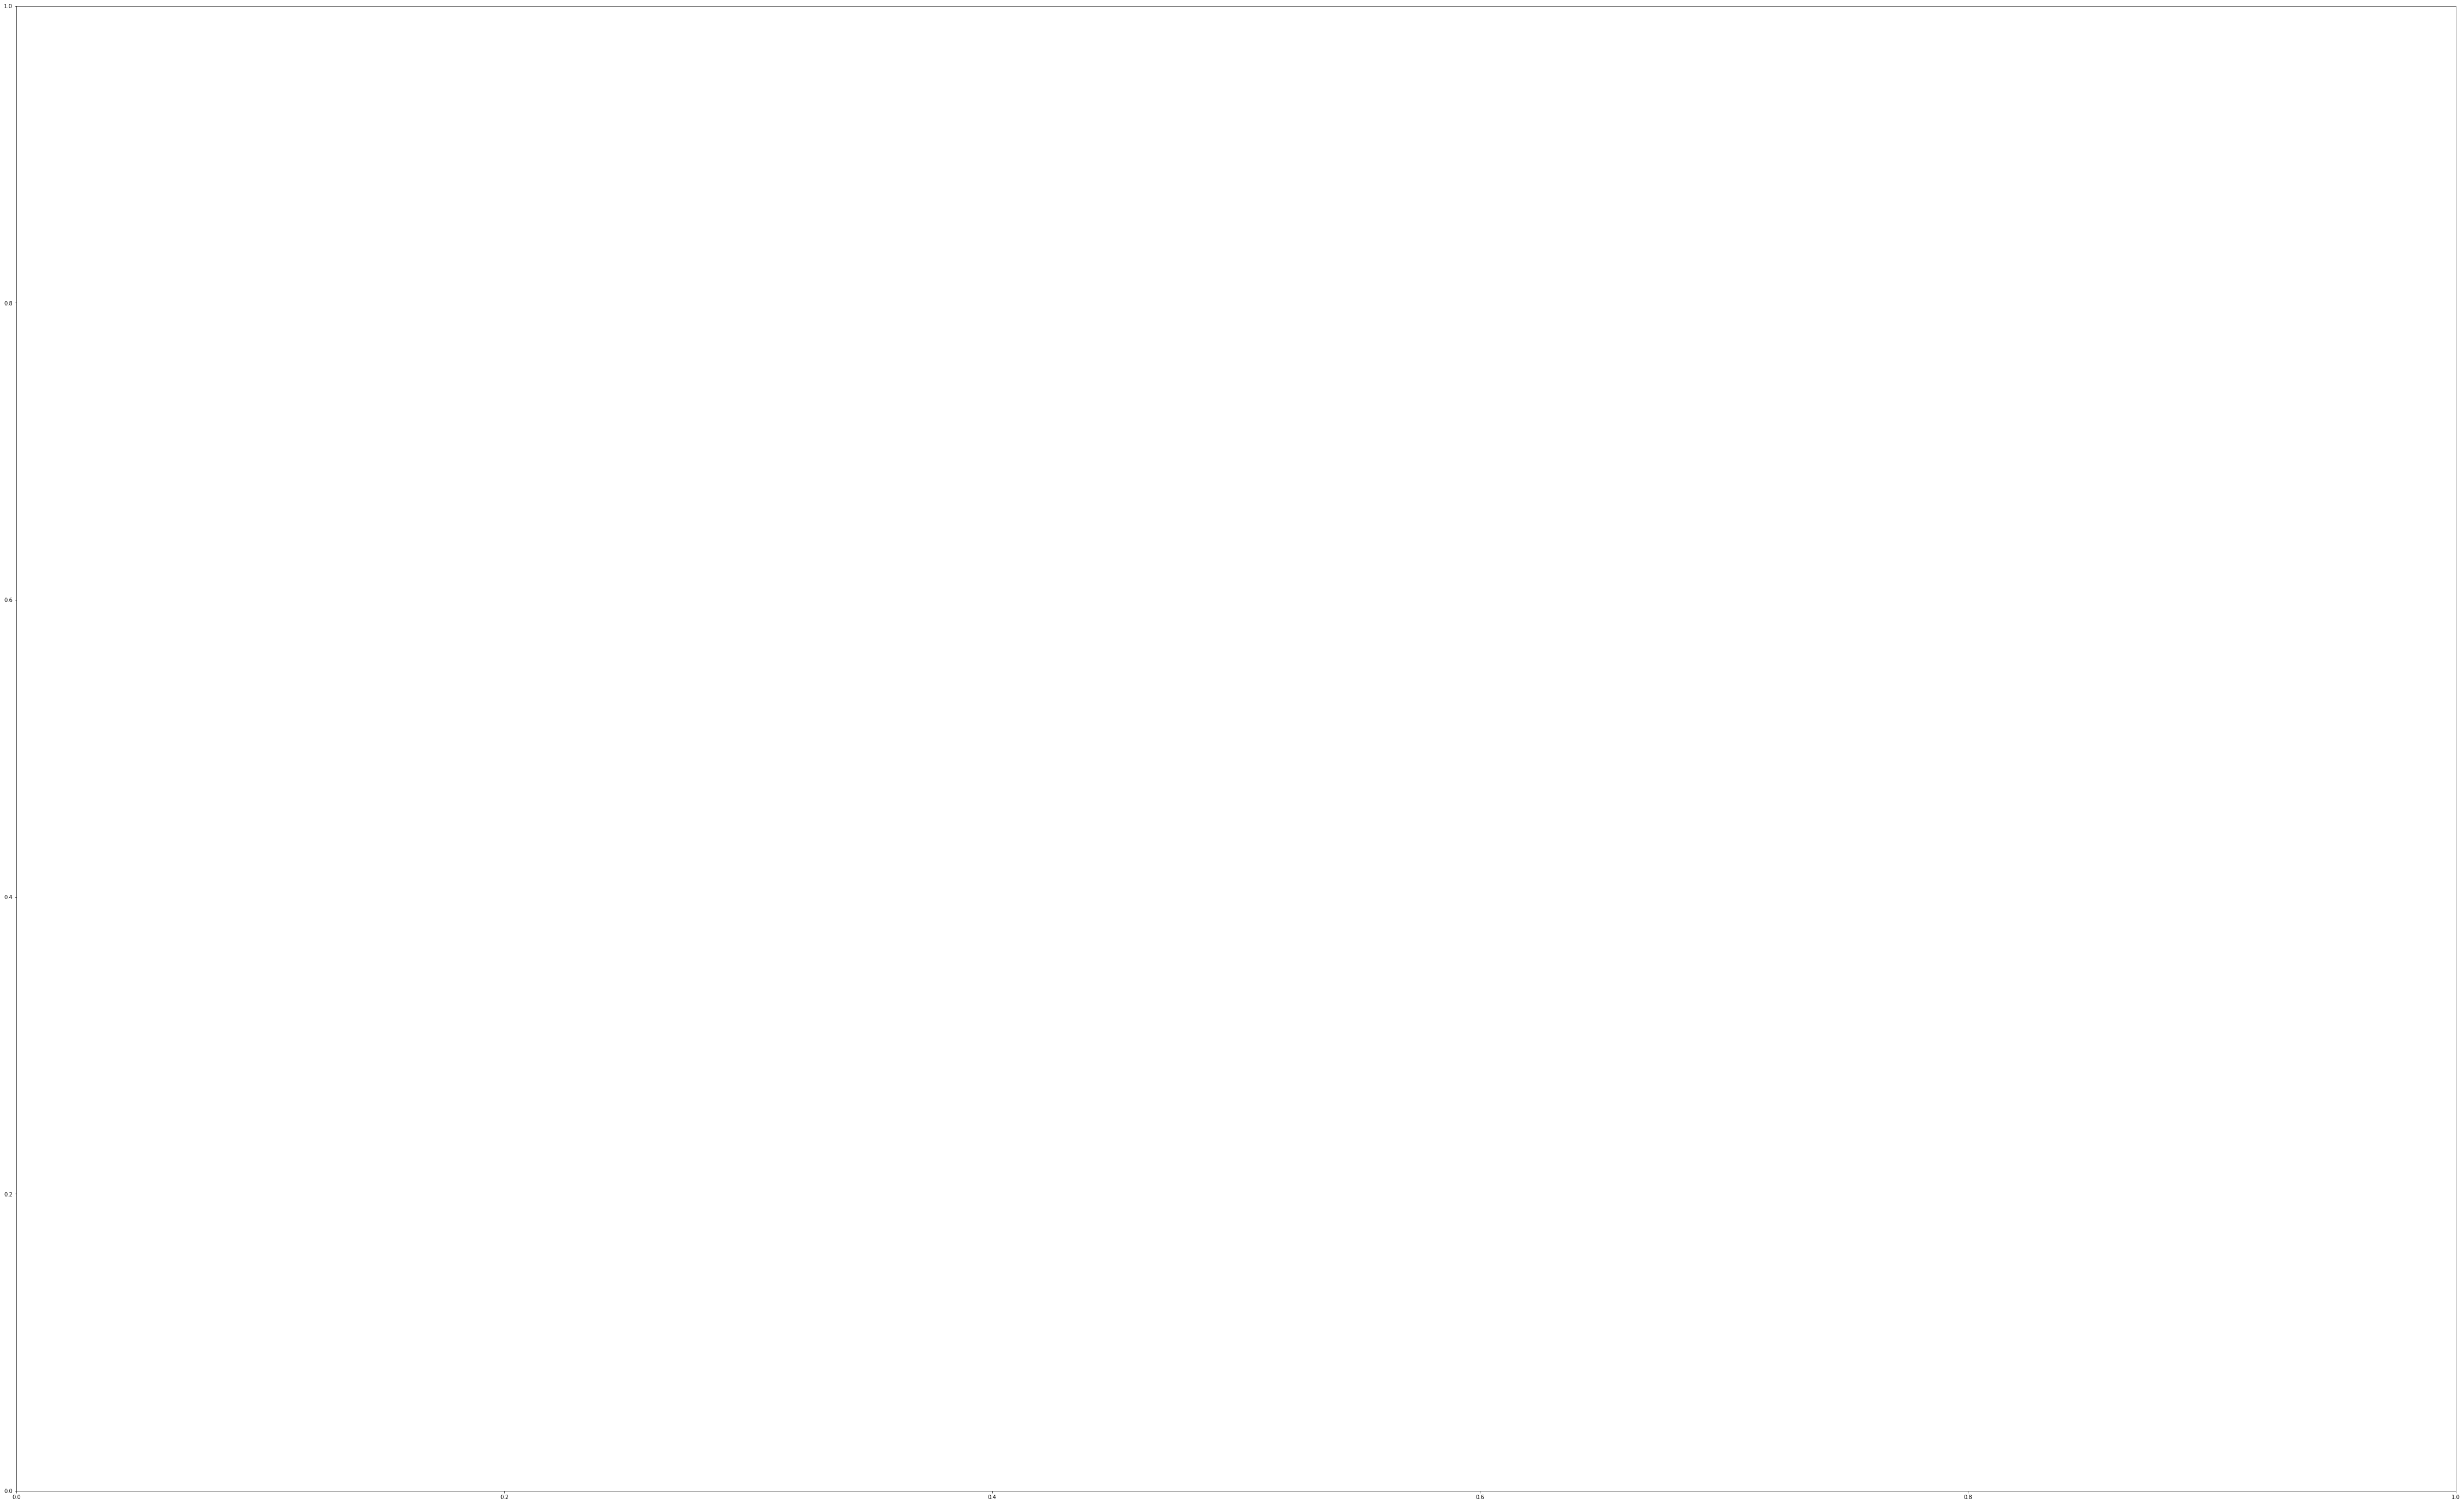

In [34]:
# Comment out to save memory

rcParams['figure.figsize'] = 80,50
plot_tree(XGB)
fig = plt.gcf()
fig.set_size_inches(50, 30)
fig.savefig('tree.eps')

In [ ]:
feat_imp = pd.Series(XGB.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar')
plt.xticks(size = 50)
plt.yticks(size = 60)
plt.suptitle('Feature Importances', fontsize=60)
plt.ylabel('Feature Importance Score', size = 60)
plt.savefig("FE.eps")